# MultiClass Classification of NIFTY 50 stock data sector-wise using Scikit-learn 

N.B. Each Company belongs to a particular sector( e.g.Automobile ,Banking ,Technology etc. ) in the dataset

##### GOALS : To make a model that can predict the sector a company belongs to based on its intraday opening and closing stock price. 

In [10]:
# API,Packages and libraries used for data collection,handling and manipulation 
import pandas as pd
import numpy as np
import quandl
quandl.ApiConfig.api_key='b8PZyxpczK4eMztsfqAA'
from IPython.display import clear_output

# Libraries used for visualisation
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn tools used
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [11]:
# Forming the dataset (Collecting the raw data seperately to form the actual train&test dataset)

## 1. Collecting the Ticker_symbols and sector names  
wiki_table=pd.read_html('https://en.wikipedia.org/wiki/NIFTY_50',header=0)[1]
symbols = list(wiki_table['Symbol'])# listing of the Ticker Symbols
sectors = list(wiki_table['Sector'])# Listing of the sector names
symbols[symbols.index('M&M')]='MM' # Updated a symbol to match with its dataset symbol

## Getting the Secctor names without repetition to feed int h classifier
set(sectors)

## 2. Forming a list of dataframes, each comprising the data corresponding to the company symbols in the symbols list in the same order
data = []

for s,i in zip(symbols,np.arange(len(symbols))):
    print(s)
    clear_output(wait=True)
    data.append(quandl.get("NSE/" + s.replace('.','_').replace('-','_'), start_date = "2016-01-01", end_date = "2017-12-31"))

## 3. Creating a dataframe of the actual to be used dataset and loading the data into it
stock_df = pd.DataFrame(index = symbols,columns = data[0].index)
for s,i in zip(data,np.arange(len(symbols))):
    s['Daily Change'] = (s['Close']-s['Open']) * 100/ s['Open']
    stock_df.iloc[i,:] = s['Daily Change']
stock_df['Sector'] = sectors
    
## 4. Labeling the Classes 
le = LabelEncoder()
stock_df['Sector_Encoded'] = le.fit_transform(stock_df['Sector']) 

ZEEL


In [12]:
## 5. Converting nan values to 0 and applying Principal Component Analysis (PCA)( Only for unsupervised learnig purposes)
    # The data generated by PCA acts as the actual feature data we are going to work with
X = stock_df.iloc[:,:300].values.astype(float) # Converting data into numpy array
X = np.nan_to_num(X) # Converting nan values to 0's

pca = PCA(n_components = 100) #PCA
scores = pca.fit_transform(X)
stock_df['PC1'] = scores[:,0] # Adding first 2 PC's to dataframe
stock_df['PC2'] = scores[:,1]

Y = stock_df['Sector_Encoded']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size =0.3,random_state = 42)

### APPLYING SUPERVISED LEARNING CLASSIFICATION ALGORITHMS  :

#### 1. K NEAREST NEIGHBOR CLASSIFIER

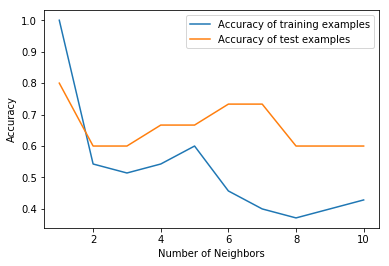

In [13]:
training_accuracy = []
test_accuracy = []

neighbor_settings=range(1,11)

# Checking the accuracy of train&test dataset at every no. of neighbors from 1 to 10 
for n_neighbor in neighbor_settings:
    clf = KNeighborsClassifier(n_neighbors=n_neighbor)
    clf.fit(X_train,Y_train)
    training_accuracy.append(clf.score(X_train,Y_train))
    test_accuracy.append(clf.score(X_test,Y_test))
# Visualising the accuracies vs no. of neighbors to get the the optimal no. of neighbors
plt.plot(neighbor_settings,training_accuracy,label='Accuracy of training examples')
plt.plot(neighbor_settings,test_accuracy,label='Accuracy of test examples')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.legend()

In [14]:
# The above plot shows that the optimal no. of neighbors is 6
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train,Y_train)
print('Accuracy of KNN n-5, on the training set: {:.3f}'.format(knn.score(X_train, Y_train)*100))
print('Accuracy of KNN n-5, on the test set: {:.3f}'.format(knn.score(X_test, Y_test)*100))

Accuracy of KNN n-5, on the training set: 45.714
Accuracy of KNN n-5, on the test set: 73.333


#### 2. SUPPORT VECTOR MACHINE

In [9]:
#Data Scaling
min_train = X_train.min(axis=0)
range_train = (X_train - min_train).max(axis=0)

X_train_scaled = (X_train - min_train)/range_train
X_test_scaled = (X_test - min_train)/range_train

# A higher value of 'C' makes a better classifier
svm = SVC(C=1000)
svm.fit(X_train_scaled, Y_train)

print('The accuracy on the training subset: {:.3f}'.format(svm.score(X_train_scaled, Y_train)*100))
print('The accuracy on the test subset: {:.3f}'.format(svm.score(X_test_scaled, Y_test)*100)) 

The accuracy on the training subset: 100.000
The accuracy on the test subset: 93.333


#### 3. RANDOM FOREST

In [8]:
forest = RandomForestClassifier(n_estimators = 2000,random_state = 42)
forest.fit(X_train,Y_train)

print("Accuracy on the training subset is: {:.3f}".format(forest.score(X_train, Y_train)*100))
print("Accuracy on the test subset is: {:.3f}".format(forest.score(X_test,Y_test)*100))

Accuracy on the training subset is: 100.000
Accuracy on the test subset is: 86.667


#### 4. MULTILAYER NEURAL NETWORK

In [15]:
# Data Scaling
scaler = StandardScaler()
X_scaled_training = scaler.fit(X_train).transform(X_train)
X_scaled_test = scaler.fit(X_test).transform(X_test)

mlp = MLPClassifier(max_iter=1000,random_state=0)
mlp.fit(X_scaled_training,Y_train)

print('Accuracy on the training subset: {:.3f}'.format(mlp.score(X_scaled_training, Y_train)*100))
print('Accuracy on the test subset: {:.3f}'.format(mlp.score(X_scaled_test, Y_test)*100))

Accuracy on the training subset: 100.000
Accuracy on the test subset: 66.667
